In [9]:
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
import time
import scienceplots
import torchsummary

import dataset
import data_Preprocess 
import models
import uLoss
import Metrics

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print ('device = ',device)
seed = 123 #seed必须是int，可以自行设置
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
plt.style.use('science')
plt.rcParams['text.usetex'] = False

device =  cuda:0


In [10]:
param = {
    'mesh_size':[0.1,0.1],
    'structure_size':[10,10],
    'measurements_num':7,
    'device':device,
    'is_plotInputMap':False,
    'Lambda':0.0,
    'HS_region':torch.tensor(([[[1.5,2.5],[6.9,8.4]],# region_1
                               [[4.4,8.4],[7.2,8.0]],# region_2
                               [[0.6,1.6],[5.0,6.0]],# region_3(1)
                               [[0.6,3.1],[4.0,5.0]],# region_3(2)
                               [[1.0,4.0],[0.8,2.8]],# region_4
                               [[5.6,8.6],[1.3,4.9]]])),# region_5
    'BCs':['Neumann','Convection','Radiation','Radiation'],# top,bottom,left,right
    'Heat Transfer Rate':52,
    'Convective coe':10,
    'Emissivity':0.05,
    'q':15,
    'T_a':20,
    'BC_regular':True,
    'HS_regular':False,
    'Direchlet BC':20,
    'learning_rate': 0.02,
    'epochs': 20000,
    'dis_interval': 1000,
    'is_plotLoss':True,
    'is_plotResult':False,
    'layout': '_uniform'      
    
}

In [18]:
train_set = dataset.MyDataset('Train','Co-driven',param)
test_set = dataset.MyDataset('Varyh','Co-driven',param)
train_loader = torch.utils.data.DataLoader(dataset = train_set,
                                          batch_size = 32,
                                          shuffle = False)
test_loader = torch.utils.data.DataLoader(dataset = test_set,
                                          batch_size = 100,
                                          shuffle = False)
Trues = data_Preprocess.get_Tfields('Test').unsqueeze(1)
trues = Trues[38][0]

Traing Epoch: 0, learning_rate = 0.02
loss = 34.709361, loss_hs = 34.709361, loss_inner = 0.002086
loss component -> loss_neumann = 0.058228, loss_radiation = 0.007802, loss_convection = 0.237993
Traing Epoch: 1000, learning_rate = 0.02
loss = 1.885594, loss_hs = 0.625325, loss_inner = 0.001044
loss component -> loss_neumann = 0.002398, loss_radiation = 0.005139, loss_convection = 0.041618
Traing Epoch: 2000, learning_rate = 0.02
loss = 1.598934, loss_hs = 0.432534, loss_inner = 0.001072
loss component -> loss_neumann = 0.001425, loss_radiation = 0.002895, loss_convection = 0.015802
Traing Epoch: 3000, learning_rate = 0.02
loss = 1.512088, loss_hs = 0.333580, loss_inner = 0.001075
loss component -> loss_neumann = 0.001259, loss_radiation = 0.002391, loss_convection = 0.016026
Traing Epoch: 4000, learning_rate = 0.02
loss = 1.529439, loss_hs = 0.367171, loss_inner = 0.001065
loss component -> loss_neumann = 0.001171, loss_radiation = 0.002063, loss_convection = 0.016438
Traing Epoch: 50

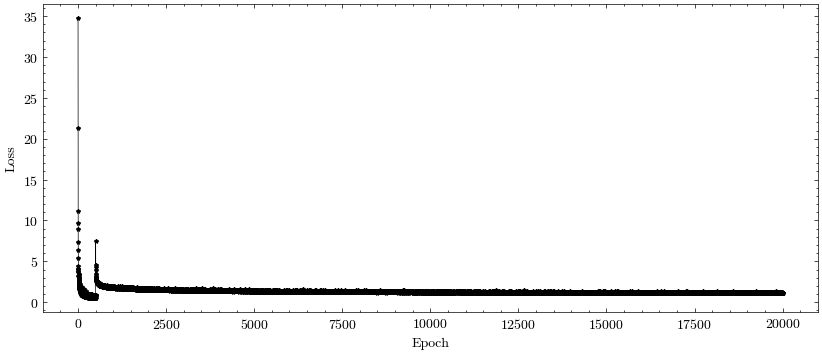

In [4]:
Unet = models.UNet(in_channels=1, out_channels=1, factors=2,param=param).to(device)
loss_fn = uLoss.UncertaintyLoss(param)
train_losses_epoch,loss_inner_epoch,loss_neumann_epoch,loss_radiation_epoch,loss_convection_epoch,loss_hsd_epoch = models._Train(Unet,train_loader,loss_fn,param)

tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.7406, grad_fn=<MeanBackward0>)
tensor(1.1675, grad_fn=<MeanBackward0>)


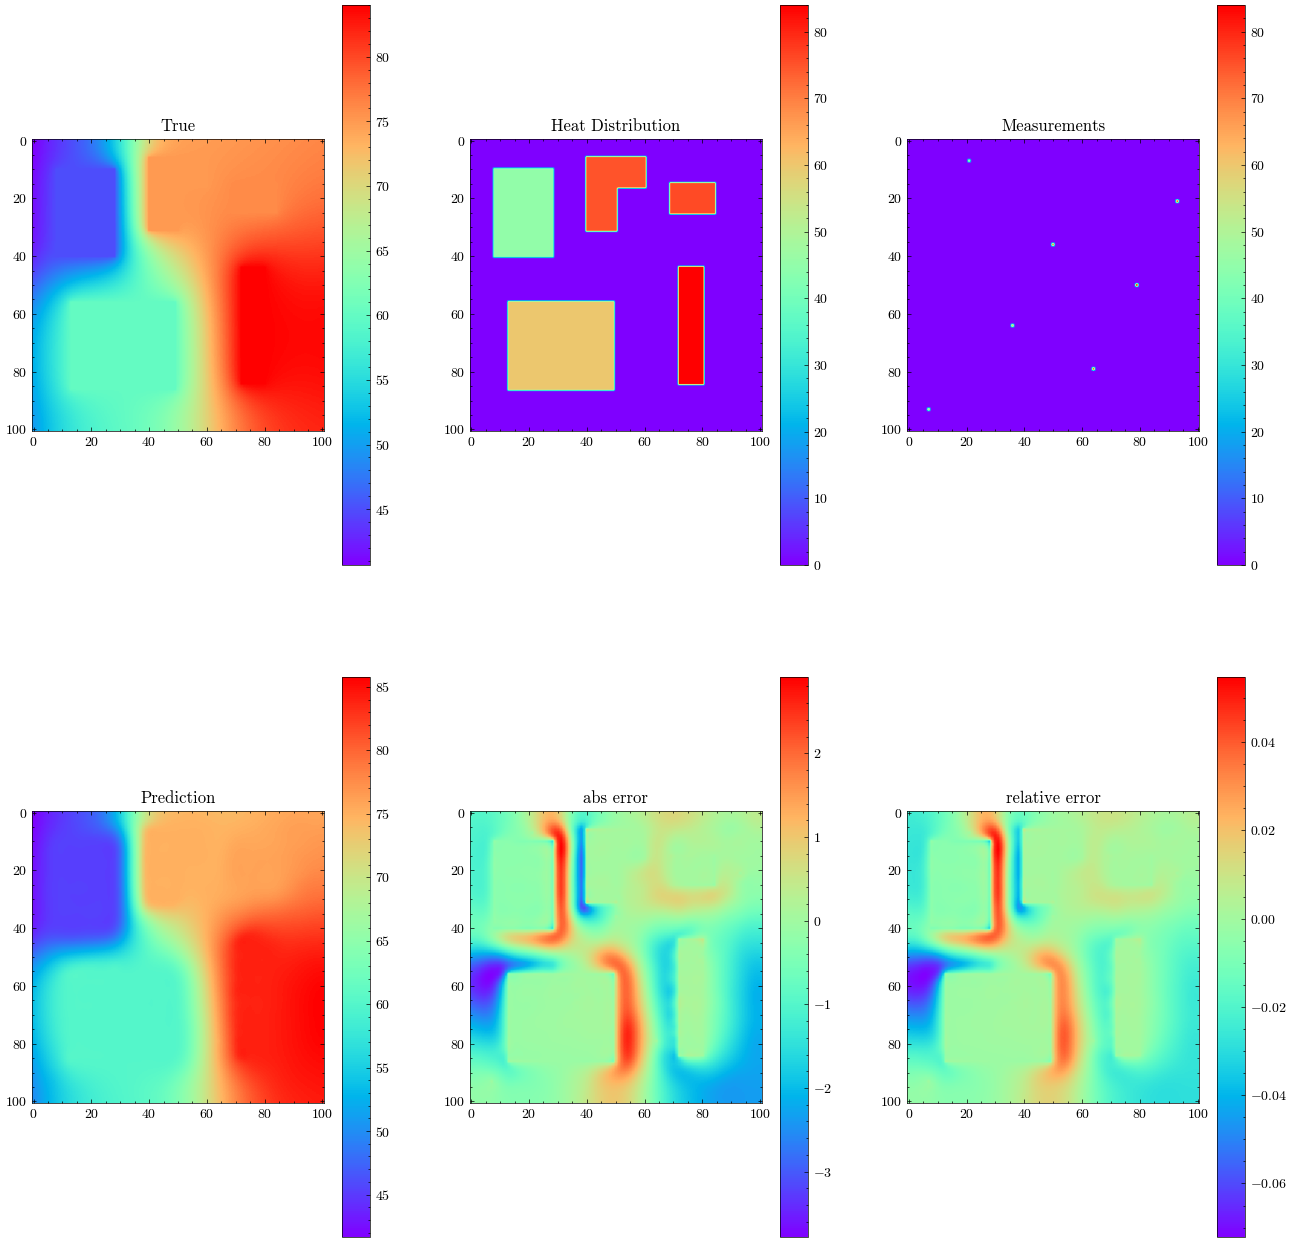

In [12]:
#Unet=torch.load('Layout-7.pt')
for idx,data in enumerate(test_loader):
    MP = data[0].clone().detach().requires_grad_(True)
    HSD = data[1].clone().detach().requires_grad_(True)
    break
out = Unet(MP.unsqueeze(1))
out = uLoss.Fill_withMeasurements(out,MP,param)
#out = uLoss.HC_Convection(out,param)
#out = uLoss.Fill_withDirechletBC(out,param)
label = 89
print (Metrics.ERMS(out[label][0],trues[label][0]))
print (Metrics.MAE(out[label][0].cpu(),trues[label][0].cpu()))
print (Metrics.MSE(out[label][0].cpu(),trues[label][0].cpu()))
plt.figure(figsize=(16,16))
plt.subplot(2,3,1)
plt.imshow(trues[label][0].cpu().detach().numpy(),cmap='rainbow')
plt.title('True')
plt.colorbar()

plt.subplot(2,3,2)
plt.imshow(HSD[label].cpu().detach().numpy(),cmap='rainbow')
plt.colorbar()
plt.title('Heat Distribution')

plt.subplot(2,3,3)
plt.imshow(MP[label].cpu().detach().numpy(),cmap='rainbow')
plt.colorbar()
plt.title('Measurements')

plt.subplot(2,3,4)
plt.imshow(out[label][0].cpu().detach().numpy(),cmap='rainbow')
plt.colorbar()
plt.title('Prediction')

plt.subplot(2,3,5)
plt.imshow((trues[label][0]-out[label][0].cpu()).detach().numpy(),cmap='rainbow')
plt.colorbar()
plt.title('abs error')

plt.subplot(2,3,6)
plt.imshow(((trues[label][0]-out[label][0].cpu())/trues[label][0]).detach().numpy(),cmap='rainbow')
plt.colorbar()
plt.title('relative error')
plt.show()

In [11]:
for idx,data in enumerate(test_loader):
    MP = data[0].clone().detach().requires_grad_(True)
    HSD = data[1].clone().detach().requires_grad_(True)
    break
since = time.time()
out = Unet(MP[0:1].unsqueeze(1))
time_elapsed = time.time() - since
time_elapsed

0.006977081298828125

torch.Size([101, 1, 1])
tensor(0.0070, grad_fn=<MeanBackward0>)
tensor(0.8757, grad_fn=<SqrtBackward0>)


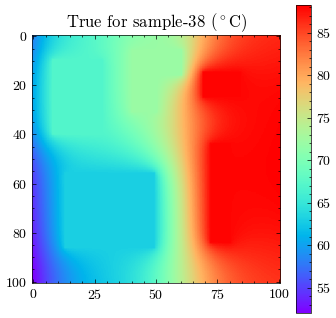

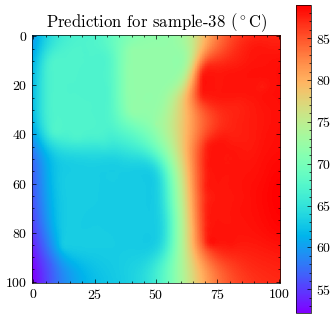

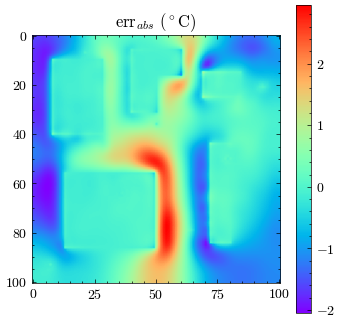

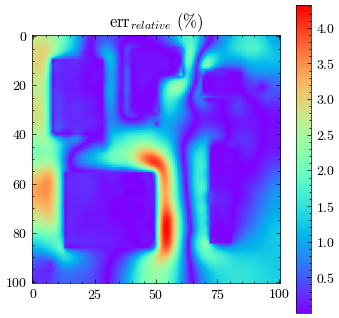

In [16]:
def NMAE(T_pred,T_true):
    maxs,indice=torch.max(torch.abs(T_true.squeeze(1).cpu()).flatten(1,-1),1)
    print (maxs.unsqueeze(-1).unsqueeze(-1).size())
    return torch.mean(torch.abs(T_true.cpu()-T_pred.cpu())/maxs.unsqueeze(-1).unsqueeze(-1))

def RMSE(T_pred,T_true):
    return torch.sqrt(torch.mean((T_true.cpu()-T_pred.cpu())**2))

print (NMAE(out[label][0],trues[label][0]))
print (RMSE(out[label][0],trues[label][0]))
label=38

plt.figure(figsize=(4,4))
plt.imshow(trues[label][0].cpu().detach().numpy(),cmap='rainbow')
plt.title('True for sample-38 ($^\circ$C)')
plt.colorbar()

plt.figure(figsize=(4,4))
plt.imshow(out[label][0].cpu().detach().numpy(),cmap='rainbow')
plt.colorbar()
plt.title('Prediction for sample-38 ($^\circ$C)')

plt.figure(figsize=(4,4))
plt.imshow((trues[label][0]-out[label][0].cpu()).detach().numpy(),cmap='rainbow')
plt.colorbar()
plt.title('err$_{abs}$ ($^\circ$C)')
plt.show()

plt.figure(figsize=(4,4))
plt.imshow(torch.abs(((trues[label][0]-out[label][0].cpu())/trues[label][0])*100).detach().numpy(),cmap='rainbow')
plt.colorbar()
plt.title('err$_{relative}$ (%)')
plt.show()

In [6]:
label=38
print ('loss_hs = {}'.format(uLoss.loss_HSD(out[label:label+1],HSD[label:label+1],param)))
print ('loss_inner = {}'.format(uLoss.loss_T_inner(out[label:label+1],param)))
print ('loss_neumann = {}'.format(uLoss.loss_neumann(out[label:label+1],param)))
print ('loss_radiation = {}'.format(uLoss.loss_radiation(out[label:label+1],param)))
print ('loss_convection = {}'.format(uLoss.loss_convection(out[label:label+1],param)))

loss_hs = 0.08666772395372391
loss_inner = 0.0004537281929515302
loss_neumann = 0.0005837703356519341
loss_radiation = 0.0007214064826257527
loss_convection = 0.0037515386939048767


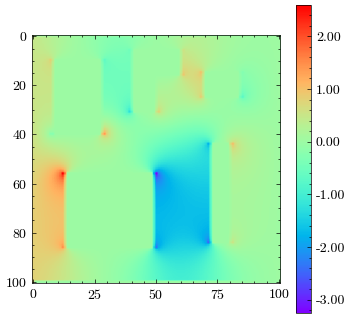

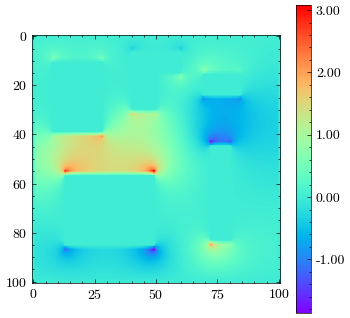

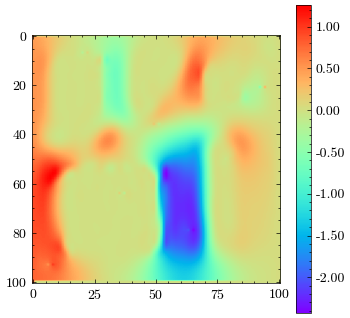

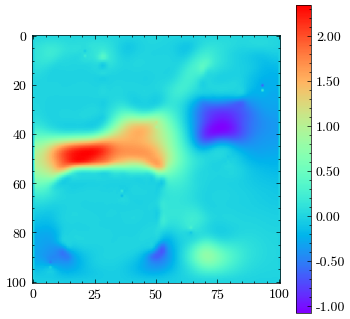

In [10]:
truth = trues[1][0].view(101,101).cpu().detach().numpy()
pred = out[1][0].view(101,101).cpu().detach().numpy() 

TG_true = data_Preprocess.compute_temperature_gradient(truth)
TG_pred = data_Preprocess.compute_temperature_gradient(pred)


plt.figure(figsize=(4,4))
img1 = plt.imshow(TG_true[:,:,0], cmap='rainbow')
cbar1 = plt.colorbar(img1, format='%.2f')

plt.figure(figsize=(4,4))
img2 = plt.imshow(TG_true[:,:,1], cmap='rainbow')
cbar2 = plt.colorbar(img2, format='%.2f')
plt.show()

plt.figure(figsize=(4,4))
img3 = plt.imshow(TG_pred[:,:,0],cmap='rainbow')
cbar3 = plt.colorbar(img3, format='%.2f')
plt.show()

plt.figure(figsize=(4,4))
img4 = plt.imshow(TG_pred[:,:,1],cmap='rainbow')
cbar4 = plt.colorbar(img4, format='%.2f')
plt.show()



torch.Size([101, 1, 1])
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.9683, grad_fn=<SqrtBackward0>)


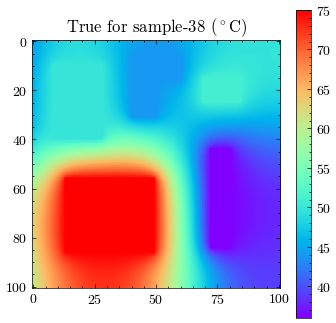

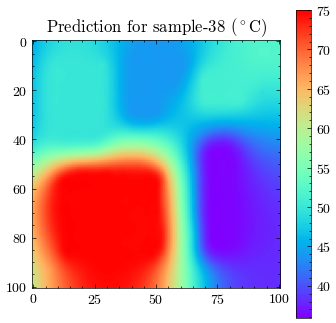

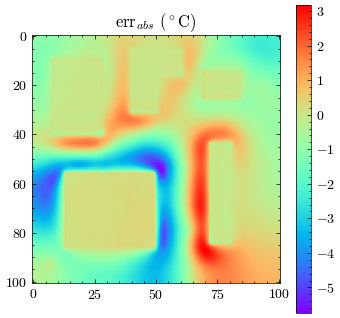

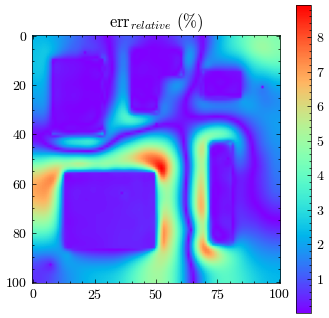

In [11]:
def NMAE(T_pred,T_true):
    maxs,indice=torch.max(torch.abs(T_true.squeeze(1).cpu()).flatten(1,-1),1)
    print (maxs.unsqueeze(-1).unsqueeze(-1).size())
    return torch.mean(torch.abs(T_true.cpu()-T_pred.cpu())/maxs.unsqueeze(-1).unsqueeze(-1))

def RMSE(T_pred,T_true):
    return torch.sqrt(torch.mean((T_true.cpu()-T_pred.cpu())**2))

print (NMAE(out[label][0],trues[label][0]))
print (RMSE(out[label][0],trues[label][0]))
label=1

plt.figure(figsize=(4,4))
plt.imshow(trues[label][0].cpu().detach().numpy(),cmap='rainbow')
plt.title('True for sample-38 ($^\circ$C)')
plt.colorbar()

plt.figure(figsize=(4,4))
plt.imshow(out[label][0].cpu().detach().numpy(),cmap='rainbow')
plt.colorbar()
plt.title('Prediction for sample-38 ($^\circ$C)')

plt.figure(figsize=(4,4))
plt.imshow((trues[label][0]-out[label][0].cpu()).detach().numpy(),cmap='rainbow')
plt.colorbar()
plt.title('err$_{abs}$ ($^\circ$C)')
plt.show()

plt.figure(figsize=(4,4))
plt.imshow(torch.abs(((trues[label][0]-out[label][0].cpu())/trues[label][0])*100).detach().numpy(),cmap='rainbow')
plt.colorbar()
plt.title('err$_{relative}$ (%)')
plt.show()

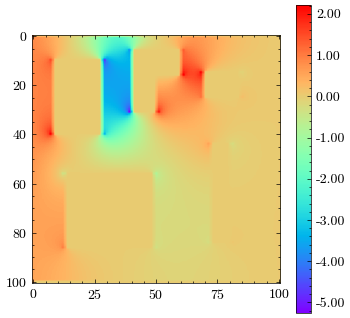

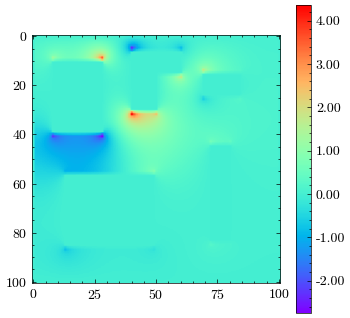

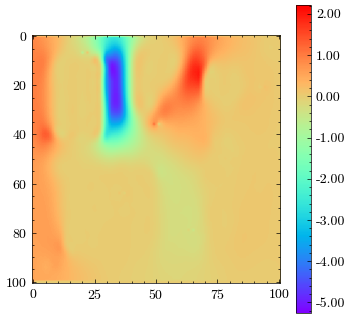

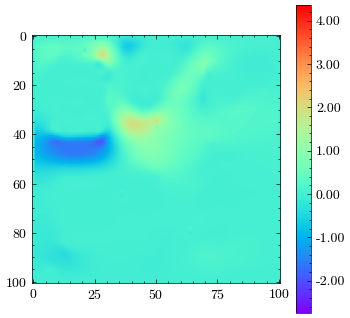

In [7]:
truth = trues[0][0].view(101,101).cpu().detach().numpy()
pred = out[0][0].view(101,101).cpu().detach().numpy() 

TG_true = data_Preprocess.compute_temperature_gradient(truth)
TG_pred = data_Preprocess.compute_temperature_gradient(pred)

min_value_x = min(TG_true[:,:,0].min(), TG_pred[:,:,0].min())
max_value_x = max(TG_true[:,:,0].max(), TG_pred[:,:,0].max())
min_value_y = min(TG_true[:,:,1].min(), TG_pred[:,:,1].min())
max_value_y = max(TG_true[:,:,1].max(), TG_pred[:,:,1].max())

plt.figure(figsize=(4,4))
img1 = plt.imshow(TG_true[:,:,0], cmap='rainbow', vmin=min_value_x, vmax=max_value_x)
cbar1 = plt.colorbar(img1, format='%.2f')

plt.figure(figsize=(4,4))
img2 = plt.imshow(TG_true[:,:,1], cmap='rainbow', vmin=min_value_y, vmax=max_value_y)
cbar2 = plt.colorbar(img2, format='%.2f')
plt.show()

plt.figure(figsize=(4,4))
img3 = plt.imshow(TG_pred[:,:,0],cmap='rainbow',vmin=min_value_x, vmax=max_value_x)
cbar3 = plt.colorbar(img3, format='%.2f')
plt.show()

plt.figure(figsize=(4,4))
img4 = plt.imshow(TG_pred[:,:,1],cmap='rainbow', vmin=min_value_y, vmax=max_value_y)
cbar4 = plt.colorbar(img4, format='%.2f')
plt.show()



In [13]:
torchsummary.summary(Unet.cuda(), (1, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 224, 224]             160
         GroupNorm-2         [-1, 16, 224, 224]              32
              ReLU-3         [-1, 16, 224, 224]               0
            Conv2d-4         [-1, 16, 224, 224]           2,320
         GroupNorm-5         [-1, 16, 224, 224]              32
              ReLU-6         [-1, 16, 224, 224]               0
     _EncoderBlock-7         [-1, 16, 224, 224]               0
         MaxPool2d-8         [-1, 16, 112, 112]               0
            Conv2d-9         [-1, 32, 112, 112]           4,640
        GroupNorm-10         [-1, 32, 112, 112]              64
             ReLU-11         [-1, 32, 112, 112]               0
           Conv2d-12         [-1, 32, 112, 112]           9,248
        GroupNorm-13         [-1, 32, 112, 112]              64
             ReLU-14         [-1, 32, 1